수치를 입력해서 다중클래스를 분류할 수 있는 모델들에 대해서 알아보겠습니다. 다중클래스 분류를 위한 데이터셋 생성을 해보고, 가장 간단한 퍼셉트론 신경망 모델부터 깊은 다층퍼셉트론 신경망 모델까지 구성 및 학습을 시켜보겠습니다.

---
### 데이터셋 준비

훈련에 사용할 임의의 값을 가진 인자 12개로 구성된 입력(x) 1000개와 각 입력에 대해 0에서 9까지 10개의 값 중 임의로 지정된 출력(y)를 가지는 데이터셋을 생성해봤습니다. 시험에 사용할 데이터는 100개 준비했습니다.

In [1]:
import numpy as np

# 데이터셋 생성
x_train = np.random.random((1000, 12))
y_train = np.random.randint(10, size=(1000, 1))
x_test = np.random.random((100, 12))
y_test = np.random.randint(10, size=(100, 1))

데이터셋의 12개 인자(x) 및 라벨값(y) 모두 무작위 수입니다. 패턴이 없는 데이터이고, 학습하기에 가장 어려운 케이스라 보실 수 있습니다. 물론 패턴이 없기 때문에 이런 데이터로 학습한 모델은 시험셋에서 정확도가 상당히 낮습니다. 하지만 이러한 무작위 데이터를 사용하는 이유는 다음과 같습니다. 

- 패턴이 없는 데이터에서 각 모델들이 얼마나 빨리 학습되는 지 살펴볼 수 있습니다
- 실제 데이터를 사용하기 전에 데이터셋 형태를 설계하거나 모델 프로토타입핑하기에 적절합니다

12개 입력인자 중 첫번째와 두번째 인자 값만 이용하여 2차원으로 데이터 분포를 살펴보겠습니다. 라벨값에 따라 점의 색상을 다르게 표시했습니다. 

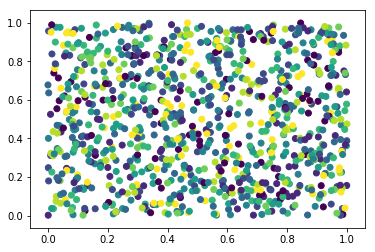

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# 데이터셋 확인 (2차원)
plot_x = x_train[:,0]
plot_y = x_train[:,1]
plot_color = y_train.reshape(1000,)

plt.scatter(plot_x, plot_y, c=plot_color)
plt.show()

![img](http://tykimos.github.io/warehouse/2017-8-19-Numerical_Input_Multiclass_Classification_Model_Recipe_output_5_0.png)

실제 데이터에서는 첫번째 인자와 두번째 인자사이의 상관관계가 있다면 그래프에서 패턴을 보실 수 있습니다. 우리는 임의의 값으로 데이터셋을 만들었으므로 예상대로 패턴을 찾을 수 없습니다. 이번에는 첫번째, 두번째, 세번째의 인자값을 이용하여 3차원으로 그래프를 확인해보겠습니다.

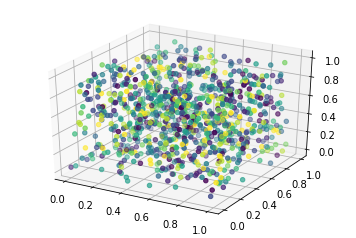

In [9]:
# 데이터셋 확인 (3차원)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plot_x = x_train[:,0]
plot_y = x_train[:,1]
plot_z = x_train[:,2]
plot_color = y_train.reshape(1000,)

ax.scatter(plot_x, plot_y, plot_z, c=plot_color)
plt.show()

![img](http://tykimos.github.io/warehouse/2017-8-19-Numerical_Input_Multiclass_Classification_Model_Recipe_output_8_0.png)

이진분류인 경우, 학습 시에는 0과 1로 값이 지정되며, 예측 시에는 0.0과 1.0 사이의 실수로 확률값이 출력됩니다. 하지만 다중클래스분류인 경우에는 클래스별로 확률값을 지정하기 위해서는 "one-hot 인코딩"을 사용합니다. 

    one-hot 인코딩이란 클래스가 3개일 때, 3개의 값을 가지는 행벡터로 구성하는 것을 얘기합니다. 삼각형, 사각형, 원을 구분한다고 했을 때, 학습 시에 삼각형 라벨은 [1 0 0], 사각형 라벨은 [0 1 0], 원은 [0 0 1]로 지정합니다. 출력 또한 3개의 값을 가지는 행벡터로 나오는데, 만약 [0.2 0.1 0.7] 이렇게 나왔다면, 삼각형일 확률이 20%, 사각형일 확률이 10%, 원일 확률이 70%임을 뜻하고 이를 모두 더하면 100%가 됩니다.

one-hot 인코딩은 아래 코드와 같이 케라스에서 제공하는 "to_categorical()"로 쉽게 처리할 수 있습니다 

In [ ]:
y_train = np.random.randint(10, size=(1000, 1))
y_train = to_categorical(y_train, num_classes=10) # one-hot 인코딩

y_test = np.random.randint(10, size=(100, 1))
y_test = to_categorical(y_test, num_classes=10) # one-hot 인코딩

---
### 레이어 준비

본 장에서 새롭게 소개되는 블록은 'softmax'입니다.

|블록|이름|설명|
|:-:|:-:|:-|
|![img](http://tykimos.github.io/warehouse/DeepBrick/Model_Recipe_Part_Activation_softmax_s.png)|softmax|활성화 함수로 입력되는 값을 클래스별로 확률 값이 나오도록 출력시킵니다. 이 확률값을 모두 더하면 1이 됩니다. 다중클래스 모델의 출력층에 주로 사용되며, 확률값이 가장 높은 클래스가 모델이 분류한 클래스입니다. 

---
### 모델 준비

다중클래스 분류를 하기 위해 `퍼셉트론 모델`, `다층퍼셉트론 모델`, `깊은 다층퍼셉트론 모델`을 준비했습니다.

#### 퍼셉트론 신경망 모델

Dense 레이어가 하나이고, 뉴런의 수도 하나인 가장 기본적인 퍼셉트론 모델입니다. 즉 웨이트(w) 하나, 바이어스(b) 하나로 전형적인  Y = w * X + b를 풀기 위한 모델입니다. 다중클래스분류이므로 출력 레이어는 softmax 활성화 함수를 사용하였습니다.

    model = Sequential()
    model.add(Dense(10, input_dim=12, activation='softmax'))
    
또는 활성화 함수를 브릭을 쌓듯이 별로 레이어로 구성하여도 동일한 모델입니다.

    model = Sequential()
    model.add(Dense(10, input_dim=12))
    model.add(Activation('softmax'))

![img](http://tykimos.github.io/warehouse/2017-8-19-Numerical_Input_Multiclass_Classification_Model_Recipe_1m.png)

#### 다층퍼셉트론 신경망 모델

Dense 레이어가 두 개인 다층퍼셉트론 모델입니다. 첫 번째 레이어는 64개의 뉴런을 가진 Dense 레이어이고 오류역전파가 용이한 `relu` 활성화 함수를 사용하였습니다. 출력 레이어인 두 번째 레이어는 클래스별 확률값을 출력하기 위해 10개의 뉴런과 `softmax` 활성화 함수를 사용했습니다.

    model = Sequential()
    model.add(Dense(64, input_dim=12, activation='relu'))
    model.add(Dense(10, activation='softmax'))

![img](http://tykimos.github.io/warehouse/2017-8-19-Numerical_Input_Multiclass_Classification_Model_Recipe_2m.png)

#### 깊은 다층퍼셉트론 신경망 모델

Dense 레이어가 총 세 개인 다층퍼셉트론 모델입니다. 첫 번째, 두 번째 레이어는 64개의 뉴런을 가진 Dense 레이어이고 오류역전파가 용이한 `relu` 활성화 함수를 사용하였습니다. 출력 레이어인 세 번째 레이어는 클래스별 확률값을 출력하기 위해 10개의 뉴런과 `softmax` 활성화 함수를 사용했습니다.

    model = Sequential()
    model.add(Dense(64, input_dim=12, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
![img](http://tykimos.github.io/warehouse/2017-8-19-Numerical_Input_Multiclass_Classification_Model_Recipe_3m.png)

---
### 전체 소스

앞서 살펴본 `퍼셉트론 신경망 모델`, `다층퍼셉트론 신경망 모델`, `깊은 다층퍼셉트론 신경망 모델`의 전체 소스는 다음과 같습니다.

#### 퍼셉트론 신경망 모델

Epoch 1/1000
1000/1000 [==============================] - 0s - loss: 2.6020 - acc: 0.0880     
Epoch 2/1000
1000/1000 [==============================] - 0s - loss: 2.5401 - acc: 0.0870     
Epoch 3/1000
1000/1000 [==============================] - 0s - loss: 2.4952 - acc: 0.0880     
Epoch 4/1000
1000/1000 [==============================] - 0s - loss: 2.4586 - acc: 0.0870     
Epoch 5/1000
1000/1000 [==============================] - 0s - loss: 2.4292 - acc: 0.0850     
Epoch 6/1000
1000/1000 [==============================] - 0s - loss: 2.4049 - acc: 0.0880     
Epoch 7/1000
1000/1000 [==============================] - 0s - loss: 2.3852 - acc: 0.0940     
Epoch 8/1000
1000/1000 [==============================] - 0s - loss: 2.3702 - acc: 0.0910     
Epoch 9/1000
1000/1000 [==============================] - 0s - loss: 2.3585 - acc: 0.0990     
Epoch 10/1000
1000/1000 [==============================] - 0s - loss: 2.3498 - acc: 0.1000     
Epoch 11/1000
1000/1000 [========================

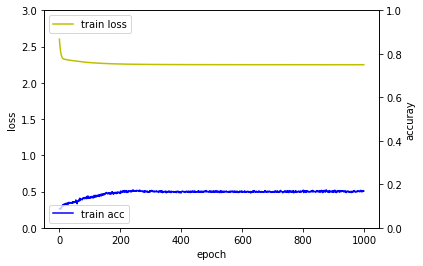

In [13]:
# 0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import random

# 1. 데이터셋 생성하기
x_train = np.random.random((1000, 12))
y_train = np.random.randint(10, size=(1000, 1))
y_train = to_categorical(y_train, num_classes=10) # one-hot 인코딩
x_test = np.random.random((100, 12))
y_test = np.random.randint(10, size=(100, 1))
y_test = to_categorical(y_test, num_classes=10) # one-hot 인코딩

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(10, input_dim=12, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=1000, batch_size=64)

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 3.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('loss_and_metrics : ' + str(loss_and_metrics))

#### 다층퍼셉트론 신경망 모델

Epoch 1/1000
1000/1000 [==============================] - 0s - loss: 2.3361 - acc: 0.1180     
Epoch 2/1000
1000/1000 [==============================] - 0s - loss: 2.2997 - acc: 0.1210     
Epoch 3/1000
1000/1000 [==============================] - 0s - loss: 2.2886 - acc: 0.1340     
Epoch 4/1000
1000/1000 [==============================] - 0s - loss: 2.2832 - acc: 0.1350     
Epoch 5/1000
1000/1000 [==============================] - 0s - loss: 2.2810 - acc: 0.1270     
Epoch 6/1000
1000/1000 [==============================] - 0s - loss: 2.2777 - acc: 0.1390     
Epoch 7/1000
1000/1000 [==============================] - 0s - loss: 2.2758 - acc: 0.1390     
Epoch 8/1000
1000/1000 [==============================] - 0s - loss: 2.2730 - acc: 0.1410     
Epoch 9/1000
1000/1000 [==============================] - 0s - loss: 2.2708 - acc: 0.1500     
Epoch 10/1000
1000/1000 [==============================] - 0s - loss: 2.2682 - acc: 0.1450     
Epoch 11/1000
1000/1000 [========================

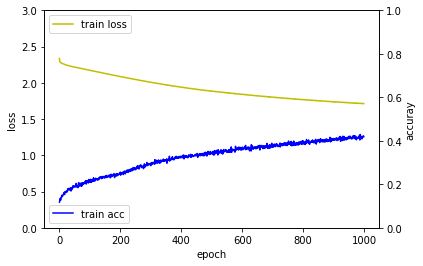

In [11]:
# 0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import random

# 1. 데이터셋 준비하기
x_train = np.random.random((1000, 12))
y_train = np.random.randint(10, size=(1000, 1))
y_train = to_categorical(y_train, num_classes=10) # one-hot 인코딩
x_test = np.random.random((100, 12))
y_test = np.random.randint(10, size=(100, 1))
y_test = to_categorical(y_test, num_classes=10) # one-hot 인코딩

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(64, input_dim=12, activation='relu'))
model.add(Dense(10, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=1000, batch_size=64)

# 5. 학습과정 확인하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 3.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('loss_and_metrics : ' + str(loss_and_metrics))

#### 깊은 다층퍼셉트론 신경망 모델

Epoch 1/1000
1000/1000 [==============================] - 0s - loss: 2.3033 - acc: 0.1010     
Epoch 2/1000
1000/1000 [==============================] - 0s - loss: 2.2918 - acc: 0.1080     
Epoch 3/1000
1000/1000 [==============================] - 0s - loss: 2.2848 - acc: 0.1210     
Epoch 4/1000
1000/1000 [==============================] - 0s - loss: 2.2801 - acc: 0.1230     
Epoch 5/1000
1000/1000 [==============================] - 0s - loss: 2.2754 - acc: 0.1420     
Epoch 6/1000
1000/1000 [==============================] - 0s - loss: 2.2711 - acc: 0.1510     
Epoch 7/1000
1000/1000 [==============================] - 0s - loss: 2.2670 - acc: 0.1620     
Epoch 8/1000
1000/1000 [==============================] - 0s - loss: 2.2622 - acc: 0.1640     
Epoch 9/1000
1000/1000 [==============================] - 0s - loss: 2.2591 - acc: 0.1530     
Epoch 10/1000
1000/1000 [==============================] - 0s - loss: 2.2543 - acc: 0.1520     
Epoch 11/1000
1000/1000 [========================

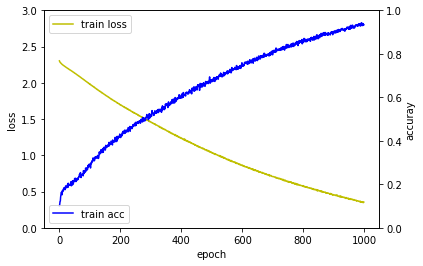

In [12]:
# 0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import random

# 1. 데이터셋 준비하기
x_train = np.random.random((1000, 12))
y_train = np.random.randint(10, size=(1000, 1))
y_train = to_categorical(y_train, num_classes=10) # one-hot 인코딩
x_test = np.random.random((100, 12))
y_test = np.random.randint(10, size=(100, 1))
y_test = to_categorical(y_test, num_classes=10) # one-hot 인코딩

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(64, input_dim=12, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=1000, batch_size=64)

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 3.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('loss_and_metrics : ' + str(loss_and_metrics))

---

### 학습결과 비교

퍼셉트론 신경망 모델 > 다층퍼셉트론 신경망 모델 > 깊은 다층퍼셉트론 신경망 모델 순으로 학습이 좀 더 빨리 되는 것을 확인할 수 있습니다.

|퍼셉트론 신경망 모델|다층퍼셉트론 신경망 모델|깊은 다층퍼셉트론 신경망 모델|
|:-:|:-:|:-:|
|![img](http://tykimos.github.io/warehouse/2017-8-19-Numerical_Input_Multiclass_Classification_Model_Recipe_output_18_1.png)|![img](http://tykimos.github.io/warehouse/2017-8-19-Numerical_Input_Multiclass_Classification_Model_Recipe_output_20_1.png)|![img](http://tykimos.github.io/warehouse/2017-8-19-Numerical_Input_Multiclass_Classification_Model_Recipe_output_22_1.png)|

---

### 요약

수치를 입력하여 다중클래스 분류를 할 수 있는 퍼셉트론 신경망 모델, 다층퍼셉트론 신경망 모델, 깊은 다층퍼셉트론 신경망 모델을 살펴보고, 그 성능을 확인 해봤습니다.

![img](http://tykimos.github.io/warehouse/2017-8-19-Numerical_Input_Multiclass_Classification_Model_Recipe_4m.png)

---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/lecture/)
* 이전 : [수치입력 이진분류 모델 레시피](https://tykimos.github.io/2017/08/13/Numerical_Input_Binary_Classification_Model_Recipe/)  
* 다음 : [영상입력 수치예측 모델 레시피](https://tykimos.github.io/2017/08/19/2017/8/20/Image_Input_Numerical_Prediction_Model_Recipe/)